# Test the HALO Downstreaming Pipelines for regulation potential analysis

## Load the library

In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## You  might need to compute the Mira topic models for downstreaming tasks for Now

### If you need to train the MIRA model, see the downstream_pipeline_MIRA_topics.ipynb

## Load pretrained model

In [2]:
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)               

In [3]:
path = "./data/datasets/BRCA-CAF/Mouse_Fibroblast_H5ad/S1_Fibroblast.h5ad"
adata = sc.read_h5ad(path)
adata.obs['RNA_snn_res.0.3'] = adata.obs['RNA_snn_res.0.3'].astype(str).astype('category')


In [4]:
rna_data = adata[:,adata.var.feature_types =='Gene Expression'].copy()
atac_data = adata[:,adata.var.feature_types =='Peaks'].copy()

In [5]:
sc.pp.filter_genes(rna_data,min_cells=15)
rna_data.raw = rna_data.copy()

In [6]:
sc.pp.normalize_total(rna_data,target_sum=1e4)
sc.pp.log1p(rna_data)

In [7]:
sc.pp.highly_variable_genes(rna_data,min_disp=0.2)
rna_data.var['exog'] = rna_data.var.highly_variable.copy()

In [8]:
rna_data.var['endog'] = rna_data.var.exog & (rna_data.var.dispersions_norm >0.7)

In [9]:
rna_data.var

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog
Xkr4,ENSMUSG00000051951,Gene Expression,53,True,0.499251,3.081853,2.586220,True,True
Lypla1,ENSMUSG00000025903,Gene Expression,34,True,0.258900,2.624479,0.283413,True,False
Tcea1,ENSMUSG00000033813,Gene Expression,94,False,0.622727,2.500807,-0.783404,False,False
Rgs20,ENSMUSG00000002459,Gene Expression,33,True,0.240294,2.908755,1.660862,True,True
Atp6v1h,ENSMUSG00000033793,Gene Expression,104,False,0.626621,2.444789,-1.108267,False,False
...,...,...,...,...,...,...,...,...,...
mt-Cytb,ENSMUSG00000064370,Gene Expression,995,False,3.932282,3.372047,-0.547581,False,False
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,36,False,0.216984,2.249850,-1.531837,False,False
Vamp7,ENSMUSG00000051412,Gene Expression,31,False,0.241581,2.558644,-0.035587,False,False
Tmlhe,ENSMUSG00000079834,Gene Expression,79,False,0.561979,2.646795,0.063217,False,False


In [10]:
rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()

In [11]:
# ## If there are pretrained models, load them

# rna_model = mira.topics.ExpressionTopicModel.load('MIRA/rna_topic_model.pth')
# atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/atac_topic_model.pth')

### Training the MIRA model
#### Training the RNA model

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: endog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog
Learning rate range test: 100%|██████████| 94/94 [00:03<00:00, 27.73it/s]
INFO:mira.topic_model.base:Set learning rates to: (0.0013343098877926858, 0.5132268080973116)
INFO:mira.topic_model.base:Set learning rates to: (0.012659579739218189, 0.24243117811520135)


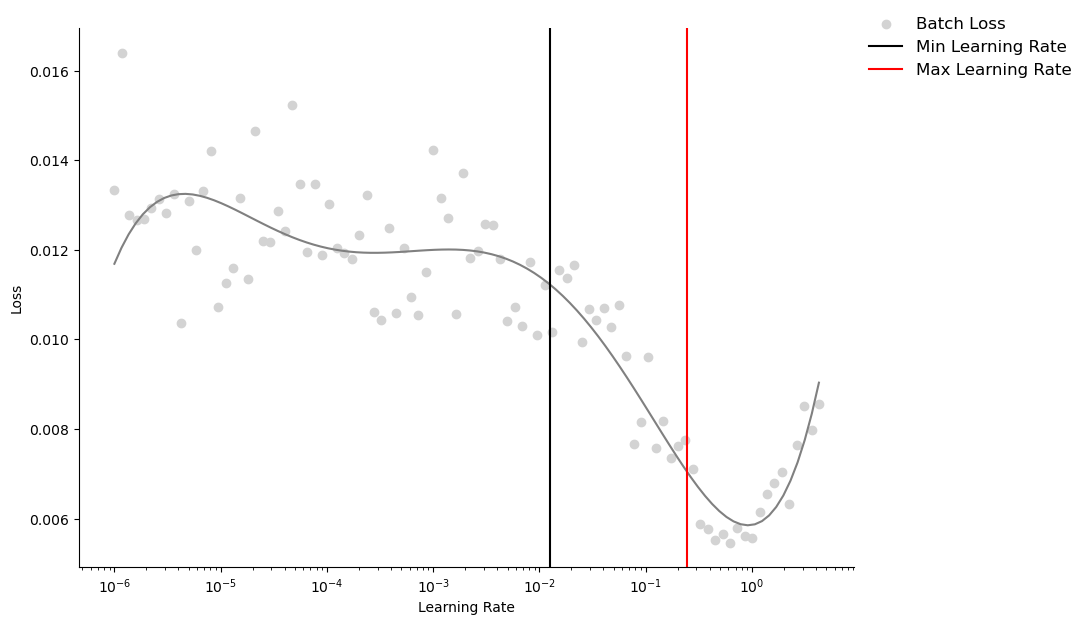

In [12]:
## Set up Rtuner
rna_model.get_learning_rate_bounds(rna_data, eval_every=1, upper_bound_lr=5)
rna_model.trim_learning_rate_bounds(2.25, 1.25)
_ = rna_model.plot_learning_rate_bounds()

In [13]:
Rtuner = mira.topics.TopicModelTuner(
    rna_model,
    save_name = 'tuning-tutorial',
    seed = 0,
    iters=30, # Recommend 30-64 iterations of tuning.
    max_topics = 10, # to speed up convergence! Leave at default of 55 when working with new data.
)
Rtuner.train_test_split(rna_data)

INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


In [14]:
Rtuner.tune(rna_data, n_workers=5)

In [15]:
Rtuner.select_best_model(rna_data, record_umaps=False)

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9090, 'encoder_dropout': 0.1038, 'kl_strategy': 'monotonic', 'num_epochs': 37, 'num_layers': 2, 'num_topics': 14}
Epoch 38 done. Recent losses: 2.374e-01 --> 2.386e-01 --> 2.355e-01 --> 2.379e-01 --> 2.378e-01: 100%|██████████| 37/37 [00:20<00:00,  1.77it/s]
INFO:mira.topic_model.trainer:Score: 2.28799e-01
INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9106, 'encoder_dropout': 0.1283, 'kl_strategy': 'cyclic', 'num_epochs': 34, 'num_layers': 2, 'num_topics': 15}
Epoch 35 done. Recent losses: 2.391e-01 --> 2.380e-01 --> 2.386e-01 --> 2.384e-01 --> 2.373e-01: 100%|██████████| 34/34 [00:19<00:00,  1.76it/s]
INFO:mira.topic_model.trainer:Score: 2.28252e-01
INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9234, 'encoder_dropout': 0.1369, 'kl_strategy': 'monotonic', 'num_epochs': 34, 'num_layers': 2, 'num_topics': 14}


ExpressionTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=14, out_features=1533, bias=False)
    (bn): BatchNorm1d(1533, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1534, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.13685710625084477, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=30, bias=True)
        (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

In [16]:
rna_model.save('MIRA/rna_topic_model_mouse_fibroblast.pth')


Predicting latent vars: 100%|██████████| 3/3 [00:00<00:00, 12.04it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


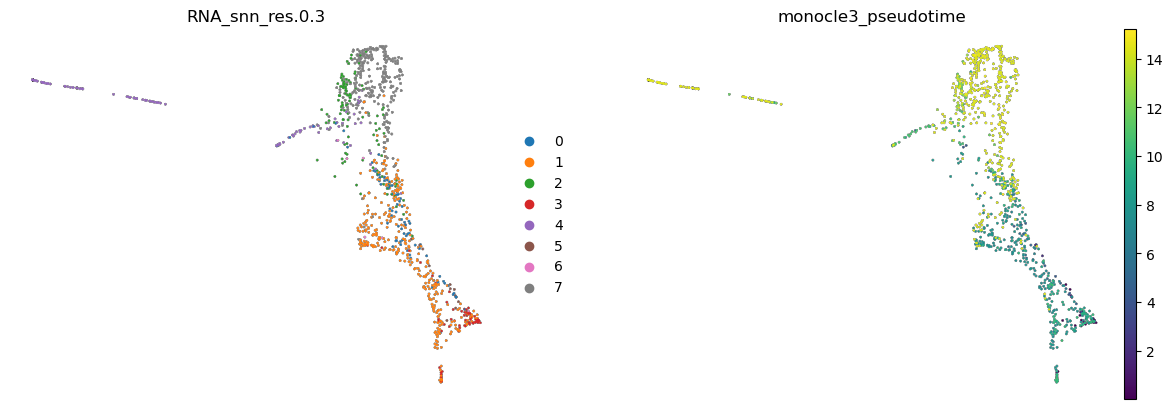

In [17]:
rna_model.predict(rna_data)
rna_model.get_umap_features(rna_data, box_cox=0.5)
sc.pp.neighbors(rna_data, use_rep = 'X_umap_features', metric = 'manhattan')
sc.tl.umap(rna_data, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(rna_data, frameon=False, size = 10, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['RNA_snn_res.0.3', "monocle3_pseudotime"])

### Training the Atac Models


In [18]:
atac_data.raw = atac_data
atac_data.layers['counts'] = atac_data.raw.to_adata().X.copy()

Learning rate range test: 100%|██████████| 94/94 [00:04<00:00, 20.16it/s]
ERROR:mira.topic_model.base:
Gradient overflow from too high learning rate, stopping test early.
INFO:mira.topic_model.base:Set learning rates to: (8.246135068635904e-06, 0.2666922799593103)
INFO:mira.topic_model.base:Set learning rates to: (8.246217530398896e-06, 0.35999692301560016)


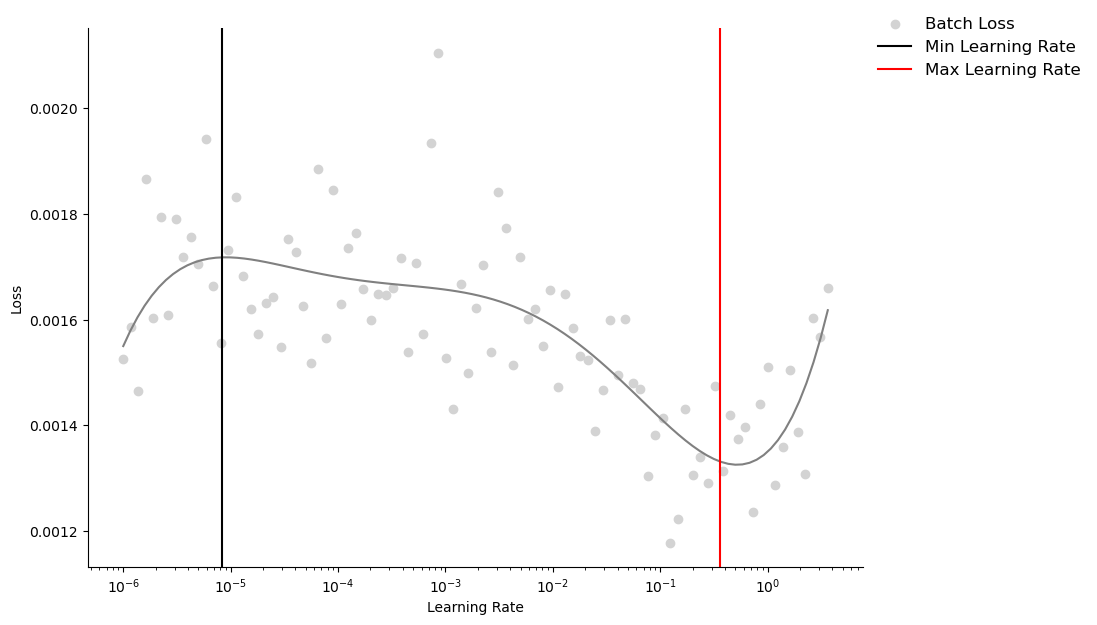

In [19]:
atac_model.get_learning_rate_bounds(atac_data, eval_every=1, upper_bound_lr=5)
atac_model.trim_learning_rate_bounds(1e-5, 0.2)
_ = atac_model.plot_learning_rate_bounds()

In [20]:
Atuner = mira.topics.TopicModelTuner(
    atac_model,
    save_name = 'ATAC',
    seed = 0,
    iters=20, # Recommend 30-64 iterations of tuning.
    max_topics = 30 # to speed up convergence! Leave at default of 55 when working with new data.
)
Atuner.train_test_split(atac_data, train_size=0.8)

INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


In [21]:
Atuner.tune(atac_data, n_workers=5)

In [22]:
Atuner.select_best_model(atac_data, record_umaps=False)
atac_model.save('MIRA/atac_topic_model_mouse_fibroblast.pth')


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9190, 'encoder_dropout': 0.0119, 'kl_strategy': 'monotonic', 'num_epochs': 35, 'num_layers': 2, 'num_topics': 15}
Epoch 36 done. Recent losses: 7.796e-02 --> 7.705e-02 --> 7.747e-02 --> 7.802e-02 --> 7.721e-02: 100%|██████████| 35/35 [00:27<00:00,  1.27it/s]
INFO:mira.topic_model.trainer:Score: 8.20427e-02
INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9024, 'encoder_dropout': 0.0129, 'kl_strategy': 'monotonic', 'num_epochs': 33, 'num_layers': 2, 'num_topics': 15}
Epoch 34 done. Recent losses: 7.740e-02 --> 7.745e-02 --> 7.698e-02 --> 7.769e-02 --> 7.796e-02: 100%|██████████| 33/33 [00:27<00:00,  1.19it/s]
INFO:mira.topic_model.trainer:Score: 8.20366e-02
INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9027, 'encoder_dropout': 0.0127, 'kl_strategy': 'monotonic', 'num_epochs': 33, 'num_layers': 2, 'num_topics'

Predicting latent vars: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


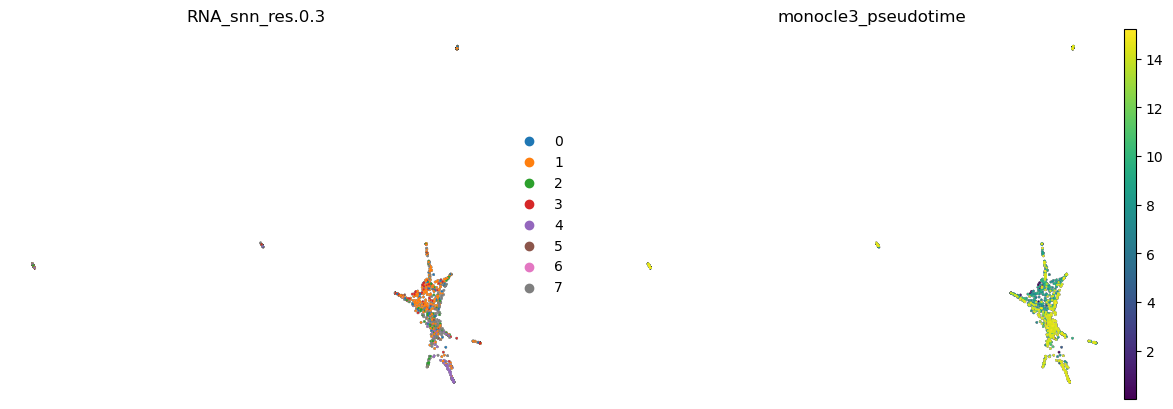

In [24]:
atac_model.predict(atac_data)
atac_model.get_umap_features(atac_data, box_cox=0.5)
sc.pp.neighbors(atac_data, use_rep = 'X_umap_features', metric = 'manhattan')
sc.tl.umap(atac_data, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(atac_data, frameon=False, size = 10, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['RNA_snn_res.0.3', "monocle3_pseudotime"])


### Save the rna data and atac data

In [ ]:
atac_data.write_h5ad("./data/datasets/BRCA-CAF/Mouse_Fibroblast_H5ad/S1_Fibroblast_atac_mira.h5ad")
rna_data.write_h5ad("./data/datasets/BRCA-CAF/Mouse_Fibroblast_H5ad/S1_Fibroblast_rna_mira.h5ad")

In [ ]:
## Mira DownStreaming Analysis
